In [74]:
import janitor
import matplotlib.pyplot as plt
import missingno
import nhanes.load
import numpy as np
import pandas as pd
import scipy.stats
import seaborn as sns
import session_info
import sklearn.compose
import sklearn.impute
import sklearn.preprocessing
import sklearn.metrics
import statsmodels.api as sm
import statsmodels.datasets
import statsmodels.formula.api as smf

from sklearn.ensemble import RandomForestRegressor
from sklearn.experimental import enable_iterative_imputer
from sklearn.kernel_approximation import Nystroem
from sklearn.linear_model import BayesianRidge, Ridge
from sklearn.neighbors import KNeighborsRegressor
from statsmodels.graphics.mosaicplot import mosaic

In [75]:
%run pandas-missing-extension.ipynb

In [76]:
nhanes_raw_df = nhanes.load.load_NHANES_data(year='2017-2018').clean_names(case_type='snake')

In [77]:
nhanes_df1 = (
    nhanes_raw_df
    .select_columns('cigarettes_smoked_per_day','minutes_sedentary_activity','how_often_do_you_snore','how_often_feel_overly_sleepy_during_day','vigorous_work_activity', 'gender')
    .rename_columns( { 'cigarettes_smoked_per_day':'cigarettes', 'minutes_sedentary_activity':'sedentary','how_often_do_you_snore':'snore','how_often_feel_overly_sleepy_during_day':'sleepy','vigorous_work_activity':'vigorous' })
    .replace( {'sedentary': {9999: np.nan}} )
)

In [78]:
nhanes_df1.dtypes # Me aseguro de que los tipos de variables que tengan sean los correctos

cigarettes    float64
sedentary     float64
snore          object
sleepy         object
vigorous      float64
gender         object
dtype: object

In [79]:
nhanes_df1.shape, nhanes_df1.size # Mi DataFrame tiene 50196 datos, 8366 observaciones y 6 variables

((8366, 6), 50196)

In [80]:
nhanes_df1.isna().sum() # Tengo demasiados datos perdidos en la variable cigarettes_smoked_per_day

cigarettes    7450
sedentary     2875
snore         2969
sleepy        2550
vigorous      2839
gender           0
dtype: int64

<AxesSubplot:>

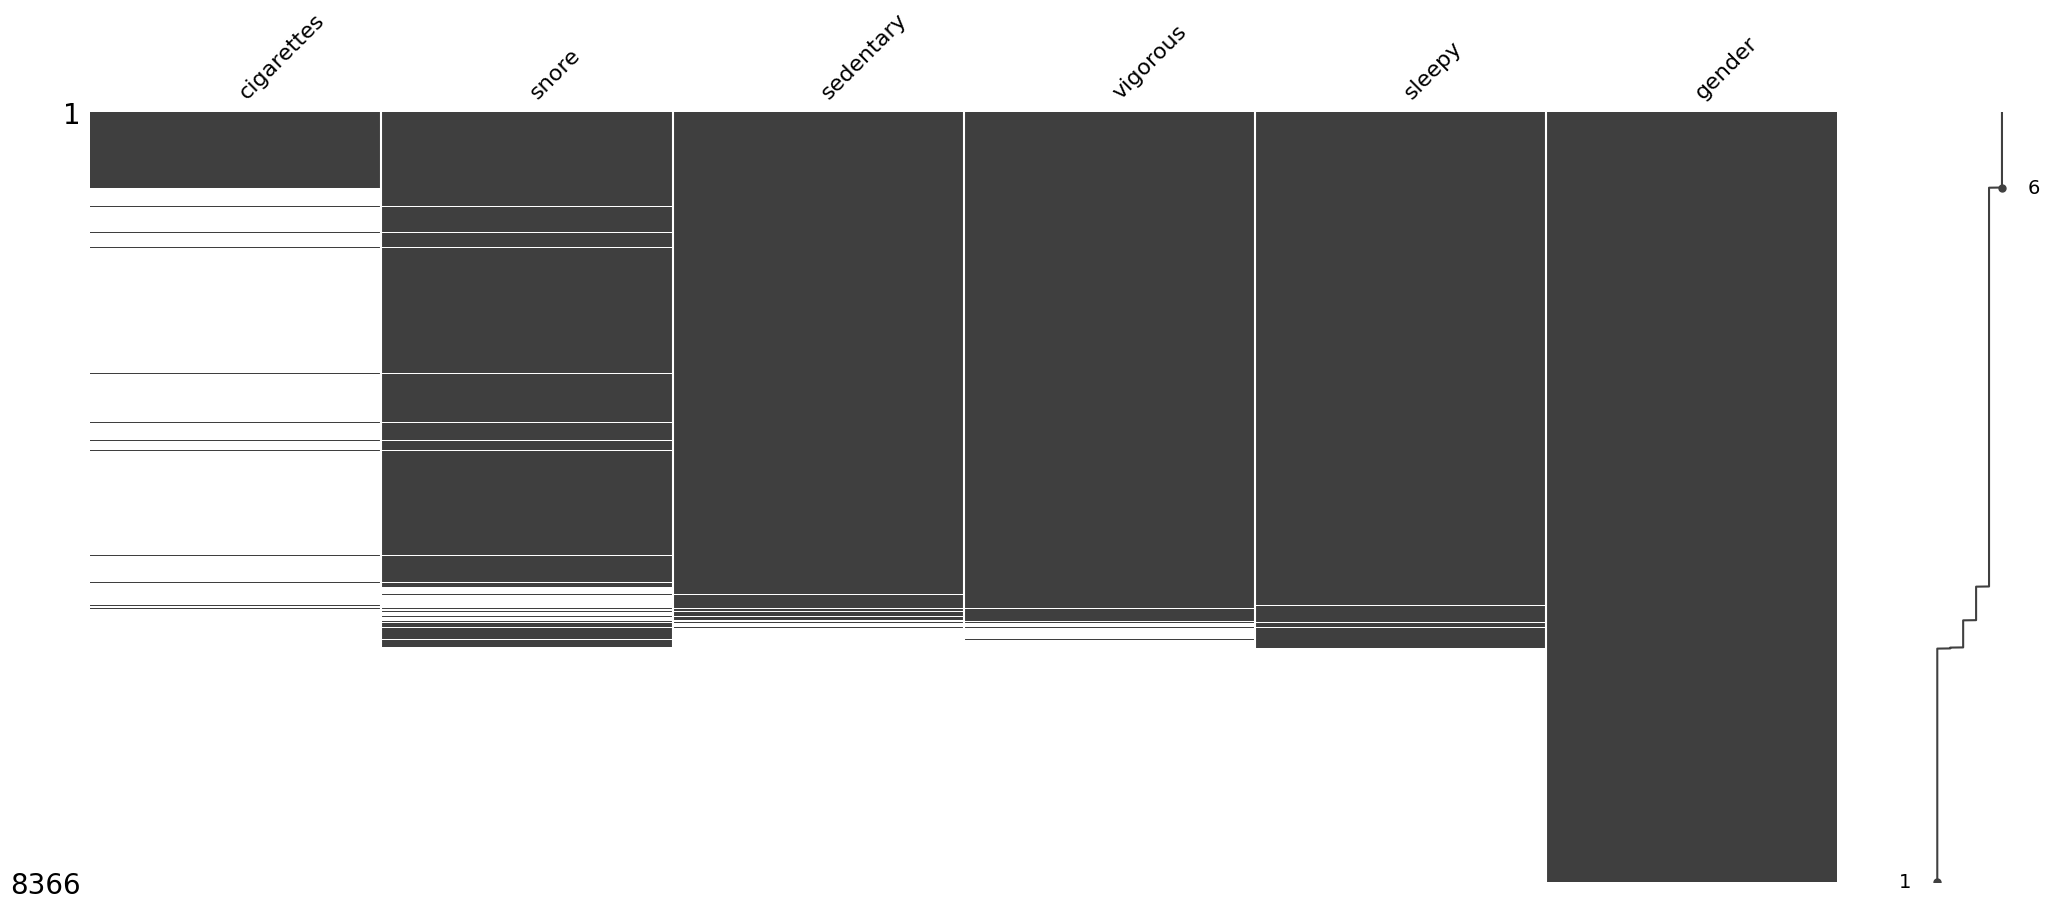

In [81]:
nhanes_df1.missing.sort_variables_by_missingness().pipe(missingno.matrix, sort='descending') # Verifico la info anterior mediante la visualizacion

{'matrix': <AxesSubplot:>,
 'shading': <AxesSubplot:>,
 'totals': <AxesSubplot:>,
 'intersections': <AxesSubplot:ylabel='Intersection size'>}

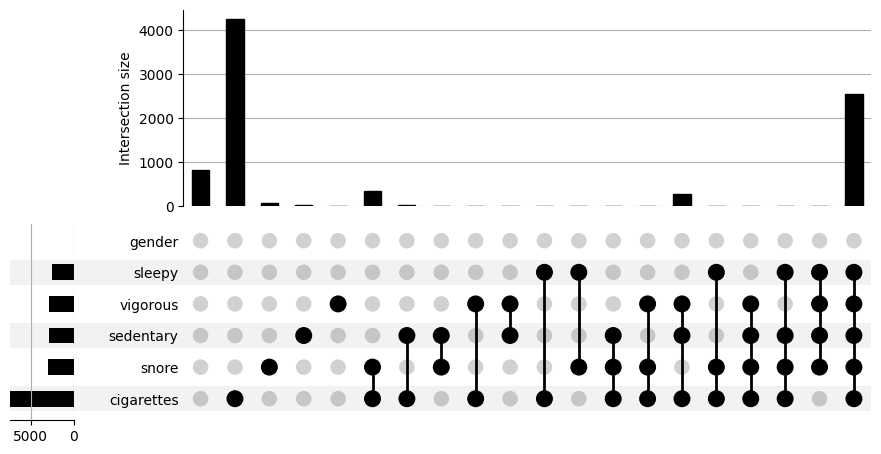

In [82]:
nhanes_df1.missing.missing_upsetplot() # Tengo muchas observaciones que no tienen datos en 5 de mis variables al tiempo

In [83]:
nhanes_df1 = nhanes_df1.dropna(subset=['cigarettes','sleepy','vigorous','snore','sedentary'], how='all') # Elimino todas las observaciones que tiene datos faltantes en las 5 variables al tiempo
nhanes_df1.size, nhanes_df1.shape # Ahora me quedo un DataFrame de 34974 datos, 5829 observaciones y 6 variables

(34974, (5829, 6))

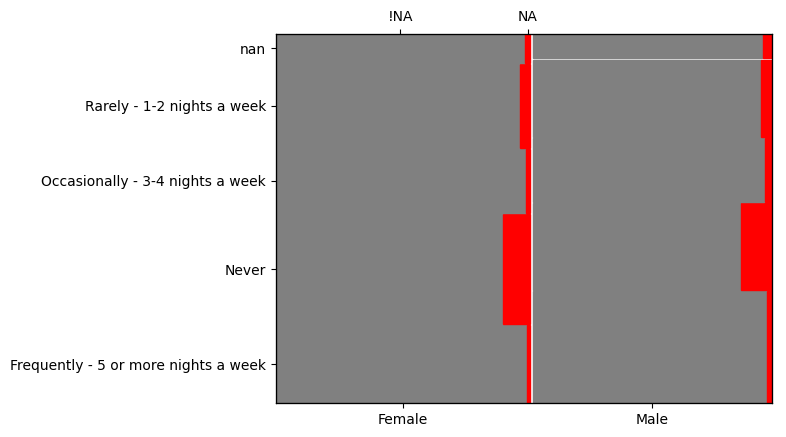

In [84]:
nhanes_df1.missing.missing_mosaic_plot(target_var='vigorous', x_categorical_var='gender', y_categorical_var='snore');

## Creo nuevo DF con las variables categoricas transformadas a numericas con OneHotEncoder

In [85]:
nhanes_df1_copy2 = nhanes_df1.copy(deep=True) # Hago copia de mi DF

cat_vars_nhanes_df1 = nhanes_df1_copy2.select_dtypes(include=[object]).columns

transformer2 = sklearn.compose.make_column_transformer((sklearn.preprocessing.OneHotEncoder() , cat_vars_nhanes_df1), remainder='passthrough')

nhanes_df1_trasnsformed2 = (
        pd.DataFrame(
    transformer2.fit_transform(nhanes_df1_copy2), 
    columns=transformer2.get_feature_names_out(),
    index=nhanes_df1_copy2.index)
    .rename_columns(function=lambda x: x.removeprefix('onehotencoder__'))
    .rename_columns(function=lambda x: x.removeprefix('remainder__'))
)

nhanes_df1_trasnsformed2

,snore_Frequently - 5 or more nights a week,snore_Never,snore_Occasionally - 3-4 nights a week,snore_Rarely - 1-2 nights a week,snore_nan,sleepy_Almost always - 16-30 times a month,sleepy_Never,sleepy_Often- 5-15 times a month,sleepy_Rarely - 1 time a month,sleepy_Sometimes - 2-4 times a month,sleepy_nan,gender_Female,gender_Male,cigarettes,sedentary,vigorous
SEQN,,,,,,,,,,,,,,,,
93705.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,NaN,300.0,0.0
93706.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,NaN,240.0,0.0
93708.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,NaN,120.0,0.0
93709.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,NaN,600.0,0.0
93711.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,NaN,420.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102949.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,20.0,60.0,1.0
102952.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,NaN,120.0,0.0
102953.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,NaN,360.0,1.0


## Creo nuevo DF con las variables categoricas transformadas a numericas con OrdinalEncoder

In [86]:
nhanes_df1_copy1 = nhanes_df1.copy(deep=True) # Hago copia de mi DF

cat_vars_nhanes_df1 = nhanes_df1_copy1.select_dtypes(include=[object]).columns # Meto mis variables categoricas en una var de Python

transformer = sklearn.compose.make_column_transformer((sklearn.preprocessing.OrdinalEncoder(), cat_vars_nhanes_df1), remainder='passthrough') # Creo el transformer

nhanes_df1_transformed = (pd.DataFrame(
    transformer.fit_transform(nhanes_df1_copy1), 
    columns= transformer.get_feature_names_out(),                                       # Creo mi DF
    index = nhanes_df1_copy1.index)
    .rename_columns(function= lambda x: x.removeprefix('ordinalencoder__'))   
    .rename_columns(function= lambda x: x.removeprefix('remainder__')) 
)                        

nhanes_df1_transformed

,snore,sleepy,gender,cigarettes,sedentary,vigorous
SEQN,,,,,,
93705.0,2.0,1.0,0.0,NaN,300.0,0.0
93706.0,3.0,3.0,1.0,NaN,240.0,0.0
93708.0,NaN,4.0,0.0,NaN,120.0,0.0
93709.0,3.0,3.0,0.0,NaN,600.0,0.0
93711.0,2.0,2.0,1.0,NaN,420.0,0.0
...,...,...,...,...,...,...
102949.0,2.0,4.0,1.0,20.0,60.0,1.0
102952.0,1.0,1.0,0.0,NaN,120.0,0.0
102953.0,1.0,4.0,1.0,NaN,360.0,1.0


## Imputacion por promedio

In [87]:
nhanes_df1.transform_column('cigarettes', lambda x: x.fillna(x.mean()), elementwise=False).cigarettes # Imputacion por PROMEDIO a la variable cigarettes

SEQN
93705.0     10.066594
93706.0     10.066594
93708.0     10.066594
93709.0     10.066594
93711.0     10.066594
              ...    
102949.0    20.000000
102952.0    10.066594
102953.0    10.066594
102954.0    10.066594
102956.0    20.000000
Name: cigarettes, Length: 5829, dtype: float64

<AxesSubplot:xlabel='sedentary', ylabel='cigarettes'>

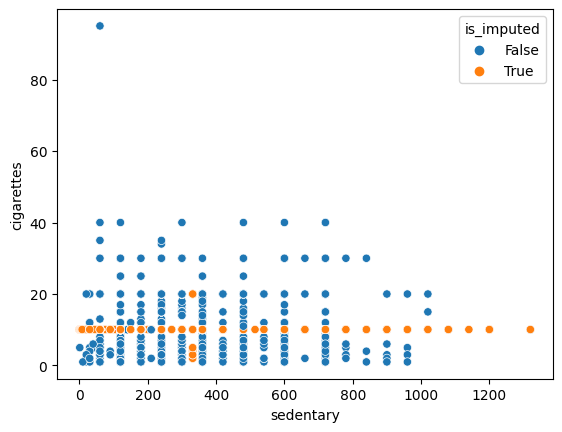

In [88]:
(
    nhanes_df1
    .select_columns('cigarettes','sedentary')                    # Visualizo como quedo mi DF para revisar si los datos imputados rompen o no las relaciones de mis variables
    .missing.bind_shadow_matrix(True, False, suffix='_imp')     
    .assign(cigarettes=lambda df: df.cigarettes.fillna(df.cigarettes.mean()), sedentary=lambda x: x.sedentary.fillna(x.sedentary.mean()))
    .missing.scatter_imputation_plot(x='sedentary', y='cigarettes')
)

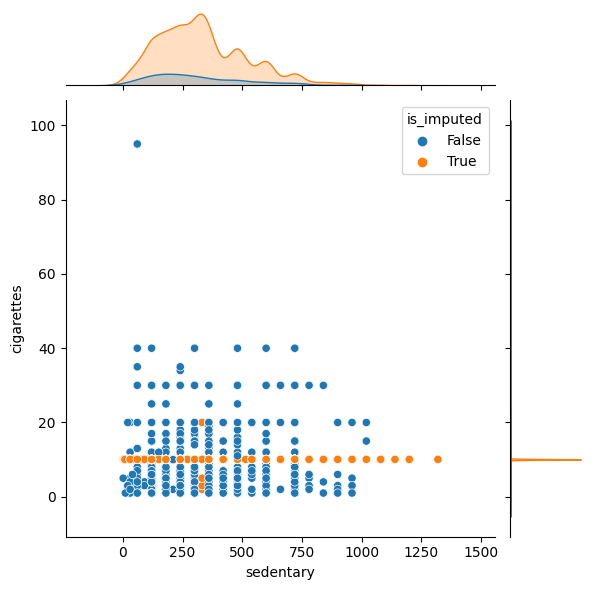

In [89]:
(
    nhanes_df1
    .select_columns('cigarettes', 'sedentary')                                      # Aqui podemos apreciar como cambia la distribucion de mis datos al imputar por la media
    .missing.bind_shadow_matrix(True, False, suffix='_imp')
    .assign(cigarettes= lambda df: df.cigarettes.fillna(df.cigarettes.mean()), sedentary= lambda df: df.sedentary.fillna(df.sedentary.mean()))
    .missing.scatter_imputation_plot(x='sedentary', y='cigarettes', show_marginal=True)  
)

## Imputacion por mediana

In [90]:
nhanes_df1.transform_column('sedentary', lambda x:x.fillna(x.median()), elementwise=False).sedentary # Imputacion por MEDIANA a la variable sedentary

SEQN
93705.0     300.0
93706.0     240.0
93708.0     120.0
93709.0     600.0
93711.0     420.0
            ...  
102949.0     60.0
102952.0    120.0
102953.0    360.0
102954.0    600.0
102956.0    720.0
Name: sedentary, Length: 5829, dtype: float64

<AxesSubplot:xlabel='sedentary', ylabel='cigarettes'>

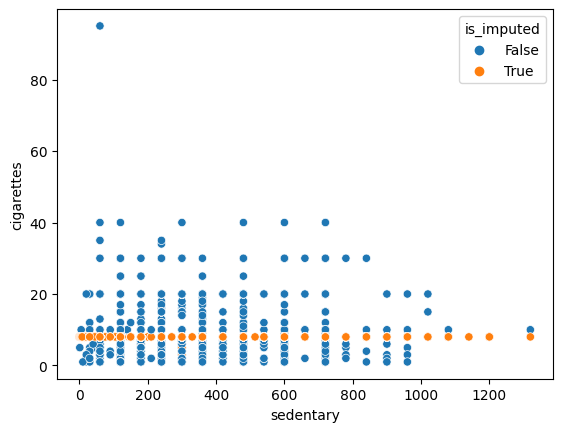

In [91]:
(
    nhanes_df1
    .select_columns('cigarettes', 'sedentary')                    # Visualizo como quedo mi DF para revisar si los datos imputados rompen o no las relaciones de mis variables
    .missing.bind_shadow_matrix(True, False, suffix='_imp')
    .assign(cigarettes= lambda x : x.cigarettes.fillna(x.cigarettes.median()), sedentary= lambda x: x.sedentary.fillna(x.sedentary.median()))
    .missing.scatter_imputation_plot(x='sedentary', y='cigarettes')
)

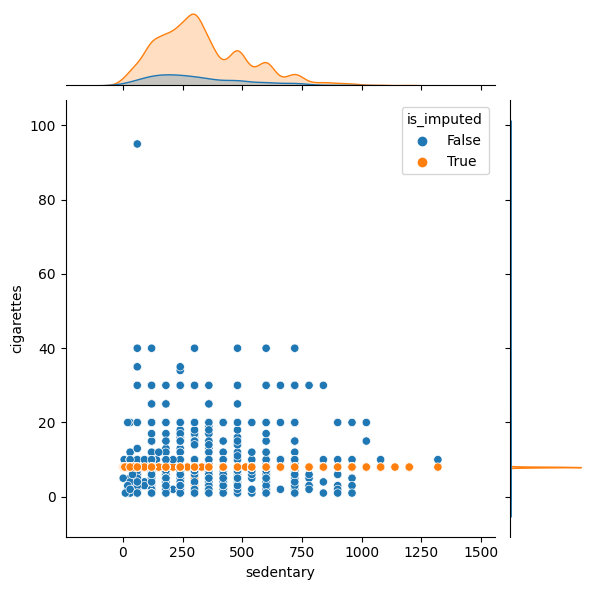

In [92]:
(
    nhanes_df1
    .select_columns('cigarettes','sedentary')                             # Aqui podemos apreciar como cambia la distribucion de mis datos al imputar por la mediana
    .missing.bind_shadow_matrix(True, False, suffix= '_imp')
    .assign(cigarettes = lambda df: df.cigarettes.fillna(df.cigarettes.median()), sedentary = lambda df: df.sedentary.fillna(df.sedentary.median()))
    .missing.scatter_imputation_plot(x='sedentary', y='cigarettes', show_marginal=True)
)

## Imputacion por llenado hacia delante

In [93]:
nhanes_df1.select_columns('cigarettes','sedentary','vigorous').ffill()  # Llenado hacia delante variables numericas

,cigarettes,sedentary,vigorous
SEQN,,,
93705.0,NaN,300.0,0.0
93706.0,NaN,240.0,0.0
93708.0,NaN,120.0,0.0
93709.0,NaN,600.0,0.0
93711.0,NaN,420.0,0.0
...,...,...,...
102949.0,20.0,60.0,1.0
102952.0,20.0,120.0,0.0
102953.0,20.0,360.0,1.0


In [94]:
(
    nhanes_df1
    .select_columns('cigarettes', 'sedentary', 'sleepy', 'gender', 'vigorous', 'snore') # Llenado hacia delante variables categoricas
    .sort_values(by = ['gender', 'cigarettes', 'vigorous', 'sleepy', 'sedentary'], ascending=True)
    .transform_column('snore', lambda x: x.ffill(), elementwise=False)
)

,cigarettes,sedentary,sleepy,gender,vigorous,snore
SEQN,,,,,,
101695.0,1.0,10.0,Almost always - 16-30 times a month,Female,0.0,Frequently - 5 or more nights a week
99920.0,1.0,240.0,Almost always - 16-30 times a month,Female,0.0,Rarely - 1-2 nights a week
100705.0,1.0,360.0,Almost always - 16-30 times a month,Female,0.0,Never
97231.0,1.0,600.0,Almost always - 16-30 times a month,Female,0.0,Frequently - 5 or more nights a week
98208.0,1.0,600.0,Almost always - 16-30 times a month,Female,0.0,Rarely - 1-2 nights a week
...,...,...,...,...,...,...
101869.0,NaN,NaN,Sometimes - 2-4 times a month,Male,NaN,Occasionally - 3-4 nights a week
102071.0,NaN,NaN,Sometimes - 2-4 times a month,Male,NaN,Rarely - 1-2 nights a week
102327.0,NaN,NaN,Sometimes - 2-4 times a month,Male,NaN,Rarely - 1-2 nights a week


## Imputacion por llenado hacia atras

In [95]:
nhanes_df1.select_columns('cigarettes', 'sedentary', 'vigorous').bfill() # Llenado hacia atras variables numericas

,cigarettes,sedentary,vigorous
SEQN,,,
93705.0,2.0,300.0,0.0
93706.0,2.0,240.0,0.0
93708.0,2.0,120.0,0.0
93709.0,2.0,600.0,0.0
93711.0,2.0,420.0,0.0
...,...,...,...
102949.0,20.0,60.0,1.0
102952.0,20.0,120.0,0.0
102953.0,20.0,360.0,1.0


In [96]:
(
    nhanes_df1
    .select_columns('cigarettes','sedentary','snore','sleepy','vigorous','gender')
    .sort_values(by=['gender', 'cigarettes', 'vigorous', 'sleepy', 'sedentary'])   # Llenado hacia atras variables categoricas
    .transform_column('snore', lambda x: x.bfill(), elementwise=False)
)

,cigarettes,sedentary,snore,sleepy,vigorous,gender
SEQN,,,,,,
101695.0,1.0,10.0,Frequently - 5 or more nights a week,Almost always - 16-30 times a month,0.0,Female
99920.0,1.0,240.0,Rarely - 1-2 nights a week,Almost always - 16-30 times a month,0.0,Female
100705.0,1.0,360.0,Never,Almost always - 16-30 times a month,0.0,Female
97231.0,1.0,600.0,Frequently - 5 or more nights a week,Almost always - 16-30 times a month,0.0,Female
98208.0,1.0,600.0,Rarely - 1-2 nights a week,Almost always - 16-30 times a month,0.0,Female
...,...,...,...,...,...,...
101869.0,NaN,NaN,Occasionally - 3-4 nights a week,Sometimes - 2-4 times a month,NaN,Male
102071.0,NaN,NaN,Rarely - 1-2 nights a week,Sometimes - 2-4 times a month,NaN,Male
102327.0,NaN,NaN,Rarely - 1-2 nights a week,Sometimes - 2-4 times a month,NaN,Male


## Imputación por vecinos más cercanos (KNN)

In [97]:
cat_vars = nhanes_df1.select_dtypes(include=[object, 'category']).columns

transformer = sklearn.compose.make_column_transformer((sklearn.preprocessing.OrdinalEncoder() ,cat_vars), remainder='passthrough')

data_transformed = (
    pd.DataFrame(
        transformer.fit_transform(nhanes_df1), columns=transformer.get_feature_names_out(), index= nhanes_df1.index)
        .rename_columns(function= lambda x: x.removeprefix('ordinalencoder__'))
        .rename_columns(function = lambda x: x.removeprefix('remainder__'))
)

In [98]:
knn_imputer = sklearn.impute.KNNImputer()

nhanes_df_knn = data_transformed.missing.sort_variables_by_missingness(ascending=True).copy(deep=True)

nhanes_df_knn.iloc[:,:] = knn_imputer.fit_transform(nhanes_df_knn).round()

nhanes_df_knn

,gender,sleepy,vigorous,sedentary,snore,cigarettes
SEQN,,,,,,
93705.0,0.0,1.0,0.0,300.0,2.0,5.0
93706.0,1.0,3.0,0.0,240.0,3.0,5.0
93708.0,0.0,4.0,0.0,120.0,2.0,8.0
93709.0,0.0,3.0,0.0,600.0,3.0,5.0
93711.0,1.0,2.0,0.0,420.0,2.0,10.0
...,...,...,...,...,...,...
102949.0,1.0,4.0,1.0,60.0,2.0,20.0
102952.0,0.0,1.0,0.0,120.0,1.0,10.0
102953.0,1.0,4.0,1.0,360.0,1.0,7.0


<AxesSubplot:xlabel='sedentary', ylabel='cigarettes'>

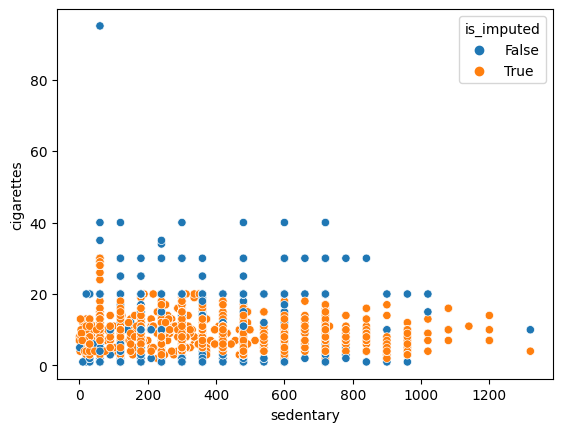

In [99]:
# Verifico que los datos que han sido imputados no rompen la estructura de mi DataFrame y tienen cierta variabilidad
(
    pd.concat(
        [nhanes_df_knn, nhanes_df1.missing.create_shadow_matrix(True, False,suffix='_imp', only_missing=True)],   
        axis=1
    )
    .missing.scatter_imputation_plot(x='sedentary', y='cigarettes')
)


## Imputacion por modelos

In [101]:
one_datavar_missing_df = (
    nhanes_df1
    .select_columns('cigarettes', 'sedentary', 'snore', 'sleepy', 'vigorous', 'gender')
    .sort_values(by = ['gender', 'vigorous','sleepy', 'snore', 'sedentary'])
    .transform_column('cigarettes', lambda x: x.bfill(), elementwise=False)
    .transform_column('snore', lambda x: x.ffill(), elementwise=False)
    .transform_column('sleepy', lambda x: x.ffill(), elementwise=False)
    .transform_column('vigorous', lambda x: x.ffill(), elementwise=False)
)

sedentary_ols = (
    one_datavar_missing_df
    .pipe(lambda df: smf.ols('sedentary ~ gender + snore + sleepy + vigorous + cigarettes', data=df))
    .fit()
)

ols_imputed_values = (  # Valores predichos para todas las observaciones de la variable sedentary
    one_datavar_missing_df
    .pipe(lambda x: x[x.sedentary.isna()])   
    .pipe(lambda x: sedentary_ols.predict(x).round())
)

one_datavar_missing_df.loc[one_datavar_missing_df.sedentary.isna() == True, ["sedentary"]] = ols_imputed_values # Accedemos solo a los valores faltantes de la variable sedentary e imputo los valores predichos para agregarlos

one_datavar_missing_df

,cigarettes,sedentary,snore,sleepy,vigorous,gender
SEQN,,,,,,
101695.0,1.0,10.0,Frequently - 5 or more nights a week,Almost always - 16-30 times a month,0.0,Female
95429.0,4.0,60.0,Frequently - 5 or more nights a week,Almost always - 16-30 times a month,0.0,Female
100024.0,4.0,60.0,Frequently - 5 or more nights a week,Almost always - 16-30 times a month,0.0,Female
102055.0,8.0,60.0,Frequently - 5 or more nights a week,Almost always - 16-30 times a month,0.0,Female
95346.0,8.0,120.0,Frequently - 5 or more nights a week,Almost always - 16-30 times a month,0.0,Female
...,...,...,...,...,...,...
102327.0,3.0,261.0,Rarely - 1-2 nights a week,Sometimes - 2-4 times a month,1.0,Male
99990.0,3.0,360.0,Rarely - 1-2 nights a week,Sometimes - 2-4 times a month,1.0,Male
97490.0,3.0,261.0,Rarely - 1-2 nights a week,Sometimes - 2-4 times a month,1.0,Male


## Imputaciones Múltiples por Ecuaciones Encadenadas (MICE)

In [102]:
categorical_vars = nhanes_df1.select_dtypes([object, 'category']).columns

transformer2 = sklearn.compose.make_column_transformer((sklearn.preprocessing.OrdinalEncoder() ,categorical_vars), remainder='passthrough')

new_df_transformed = (
    pd.DataFrame(transformer2.fit_transform(nhanes_df1), columns=transformer2.get_feature_names_out(), index=nhanes_df1.index)
    .rename_columns(function= lambda x: x.removeprefix('ordinalencoder__'))
    .rename_columns(function= lambda x: x.removeprefix('remainder__'))
)

mice_new_df_transformed = new_df_transformed.copy(deep=True)

mice_imputer = sklearn.impute.IterativeImputer(estimator=BayesianRidge())

mice_new_df_transformed.iloc[:,:] = mice_imputer.fit_transform(mice_new_df_transformed).round()

mice_new_df_transformed = (
    pd.concat([mice_new_df_transformed , new_df_transformed.missing.create_shadow_matrix(True, False, suffix='_imp', only_missing=True)],
    axis=1)
)

mice_new_df_transformed # Aqui uní los dos DataFrames para identificar que valor fue imputado y cual no

,snore,sleepy,gender,cigarettes,sedentary,vigorous,snore_imp,sleepy_imp,cigarettes_imp,sedentary_imp,vigorous_imp
SEQN,,,,,,,,,,,
93705.0,2.0,1.0,0.0,9.0,300.0,0.0,False,False,True,False,False
93706.0,3.0,3.0,1.0,9.0,240.0,0.0,False,False,True,False,False
93708.0,2.0,4.0,0.0,9.0,120.0,0.0,True,False,True,False,False
93709.0,3.0,3.0,0.0,9.0,600.0,0.0,False,False,True,False,False
93711.0,2.0,2.0,1.0,10.0,420.0,0.0,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...
102949.0,2.0,4.0,1.0,20.0,60.0,1.0,False,False,False,False,False
102952.0,1.0,1.0,0.0,10.0,120.0,0.0,False,False,True,False,False
102953.0,1.0,4.0,1.0,11.0,360.0,1.0,False,False,True,False,False


## Regreso mi DF a datos numericos y categoricos

In [103]:
imputated_df = mice_new_df_transformed.copy(deep=True)

imputated_df[categorical_vars] = (
    transformer2
    .named_transformers_
    .ordinalencoder
    .inverse_transform(
        X = imputated_df[categorical_vars]
    )
)

imputated_df

,snore,sleepy,gender,cigarettes,sedentary,vigorous,snore_imp,sleepy_imp,cigarettes_imp,sedentary_imp,vigorous_imp
SEQN,,,,,,,,,,,
93705.0,Occasionally - 3-4 nights a week,Never,Female,9.0,300.0,0.0,False,False,True,False,False
93706.0,Rarely - 1-2 nights a week,Rarely - 1 time a month,Male,9.0,240.0,0.0,False,False,True,False,False
93708.0,Occasionally - 3-4 nights a week,Sometimes - 2-4 times a month,Female,9.0,120.0,0.0,True,False,True,False,False
93709.0,Rarely - 1-2 nights a week,Rarely - 1 time a month,Female,9.0,600.0,0.0,False,False,True,False,False
93711.0,Occasionally - 3-4 nights a week,Often- 5-15 times a month,Male,10.0,420.0,0.0,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...
102949.0,Occasionally - 3-4 nights a week,Sometimes - 2-4 times a month,Male,20.0,60.0,1.0,False,False,False,False,False
102952.0,Never,Never,Female,10.0,120.0,0.0,False,False,True,False,False
102953.0,Never,Sometimes - 2-4 times a month,Male,11.0,360.0,1.0,False,False,True,False,False
